## Импорт библиотек и константы

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from rectools import Columns
from rectools.dataset import Interactions, Dataset
from rectools.models.popular import PopularModel
from rectools.metrics import MAP, Serendipity, calc_metrics
from rectools.model_selection import TimeRangeSplitter
from implicit.nearest_neighbours import CosineRecommender, TFIDFRecommender, BM25Recommender
from utils import MetricCalculator, VisualAnalyzer
from user_knn import UserKnn
from rectools.models import PopularModel
from scipy import sparse
import json

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Constants
INTERACTIONS_PATH = "./data/interactions.csv"
ITEMS_PATH = "./data/items.csv"
K_RECOMMENDATIONS = 10

## Загрузка данных

In [4]:
interactions_df = pd.read_csv(INTERACTIONS_PATH)
interactions_df = interactions_df.rename(columns={"watched_pct": "weight", "last_watch_dt": "datetime"})
interactions_df['datetime'] = pd.to_datetime(interactions_df['datetime'])
interactions_df.head(5)

,user_id,item_id,datetime,total_dur,weight
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [5]:
items_df = pd.read_csv(ITEMS_PATH)
items_df.head(5)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


## Эксперименты

### Холодные пользователи (3 балла)

__Для холодных юзеров будем использовать популярные айтемы. Ниже определим наилучшую модель для этого__

In [9]:
cold_users_interactions = Interactions(interactions_df.copy())

In [10]:
len(cold_users_interactions.df)

5476251

In [22]:
cold_users_splitter = TimeRangeSplitter(
    test_size="7D",
    n_splits=2,
    filter_already_seen=True,
    filter_cold_items=True,
    filter_cold_users=True
)

In [27]:
cold_users_metrics = {
    'map@10': MAP(k=K_RECOMMENDATIONS),
    'serendipity': Serendipity(k=K_RECOMMENDATIONS),
}

cold_users_models = {
    "popular_n_users": PopularModel(popularity="n_users"),
    "popular_n_interactions": PopularModel(popularity="n_interactions"),
    "popular_mean_weight": PopularModel(popularity="mean_weight"),
    "popular_sum_weight": PopularModel(popularity="sum_weight")
}

In [28]:
cold_users_mc = MetricCalculator(cold_users_models, cold_users_metrics, cold_users_splitter, K_RECOMMENDATIONS, cold_users_interactions)
cold_users_report_df = cold_users_mc.generate_report(show_logs=True)

Test fold: 1, model: popular_n_users, fitted in: 406 milliseconds, predicted in: 983 milliseconds
Test fold: 1, model: popular_n_interactions, fitted in: 50 milliseconds, predicted in: 4 milliseconds
Test fold: 1, model: popular_mean_weight, fitted in: 56 milliseconds, predicted in: 961 milliseconds
Test fold: 1, model: popular_sum_weight, fitted in: 57 milliseconds, predicted in: 983 milliseconds
Test fold: 2, model: popular_n_users, fitted in: 975 milliseconds, predicted in: 502 milliseconds
Test fold: 2, model: popular_n_interactions, fitted in: 54 milliseconds, predicted in: 543 milliseconds
Test fold: 2, model: popular_mean_weight, fitted in: 61 milliseconds, predicted in: 484 milliseconds
Test fold: 2, model: popular_sum_weight, fitted in: 62 milliseconds, predicted in: 562 milliseconds


In [29]:
cold_users_report_df.head()

,map@10,serendipity
model,,
popular_n_users,0.081361,0.000002
popular_n_interactions,0.081361,0.000002
popular_mean_weight,0.000000,0.000000
popular_sum_weight,0.079390,0.000003


__Можно заметить что `popular_n_users` и `popular_n_interactions` имеют одинаковое значение MAP@10, это связано с тем, что в датасете пара юзер-айтем не повторяется, поэтому количество уникальных юзеров и интеракций с айтемом равны__

__Таким образом, будем использовать топ 10 популярных айтемов для рекомендации холодным пользователям. Ниже приведен список таких айтемов. Список сохраняется при уменьшении верхней временной границы датасета, хотя и меняется порядок айтемов__

In [8]:
model = PopularModel(popularity="n_interactions")
dataset = Dataset.construct(interactions_df.copy())
model.fit(dataset)

va = VisualAnalyzer(model, dataset, [2], ["title"], K_RECOMMENDATIONS, items_df)
history_df, reco_df = va.get_history_and_recommendation_dataframes()
reco_df

,user_id,item_id,score,rank,title
0,2,10440,202457.0,1,Хрустальный
1,2,15297,193123.0,2,Клиника счастья
2,2,9728,132865.0,3,Гнев человеческий
3,2,13865,122119.0,4,Девятаев
4,2,4151,91167.0,5,Секреты семейной жизни
5,2,3734,74803.0,6,Прабабушка легкого поведения
6,2,2657,68581.0,7,Подслушано
7,2,4880,55043.0,8,Афера
8,2,142,45367.0,9,Маша
9,2,6809,40372.0,10,Дуров


### Количество рекомендаций фиксированное (3 балла)

__Для того чтобы количество рекомендаций было фиксированным (равным N), а не ниже N, нужно дополнять рекомендации популярнымм айтемами__

__Данная функция уже реализована в классе UserKnn с помощью методов `_get_cold_user_recommendations` и `finalize_recommendations`. Первый добавляет каждому пользователю популярные рекомендации, а второй отсекает и передает для рекомендации только N айтмеов__

In [21]:
fix_reco_interactions = Interactions(interactions_df.copy())

In [22]:
interactions = fix_reco_interactions

In [23]:
fix_reco_metrics = {
    'map@10': MAP(k=K_RECOMMENDATIONS),
    'serendipity': Serendipity(k=K_RECOMMENDATIONS),
}

fix_reco_models = {
    'user_knn': UserKnn(model=CosineRecommender(20), n_similar_users=20)
}

In [24]:
metrics = fix_reco_metrics
models = fix_reco_models

In [25]:
fix_reco_splitter = TimeRangeSplitter(
    test_size="7D",
    n_splits=1,
    filter_already_seen=True,
    filter_cold_items=True,
    filter_cold_users=False
)

In [ ]:
fold_iterator = fix_reco_splitter.split(interactions, collect_fold_stats=True)

fix_reco_results = []

for i_fold, (train_ids, test_ids, fold_info) in enumerate(fold_iterator):
    print(f"\n==================== Fold {i_fold}")
    df_train = fix_reco_interactions.df.iloc[train_ids].copy()
    df_test = fix_reco_interactions.df.iloc[test_ids][Columns.UserItem].copy()
    test_users = df_test[Columns.User].unique()
    catalog = df_train[Columns.Item].unique()
    
    for model_name, model in fix_reco_models.items():
        model.fit(df_train)
    
        recos = model.recommend(test_users, k=K_RECOMMENDATIONS)
    
        metric_values = calc_metrics(
            fix_reco_metrics,
            reco=recos,
            interactions=df_test,
            prev_interactions=df_train,
            catalog=catalog,
        )
    
        fold = {"fold": i_fold, "model": model_name}
        fold.update(metric_values)
        fix_reco_results.append(fold)

In [32]:
pd.DataFrame(fix_reco_results)

{'map@10': 0.0785473340543117, 'serendipity': 3.8314219041045575e-05}

Видно, что качество с использованием kNN немного ниже чем у модели с константными прогнозами, однако выше новизна рекомендаций на целый порядок. Попробуем перебрать гиперпараметры, чтобы повысить качество

## Тюниг гиперпараметров (3 балла)

__Переберем различные типы рекомендеров из implicit и количество соседей. Для того чтобы это было быстрее считать, возьмем только 5-ую часть всех пользователей__

In [60]:
tuning_interactions = Interactions(interactions_df[interactions_df[Columns.User] % 5 == 0].copy())

In [61]:
tuning_models = dict()
for n_similar_users in (10, 20, 40, 60):
    for (recommender, name) in zip((CosineRecommender, TFIDFRecommender, BM25Recommender), ("cosine", "tfidf", "bm25")):
        tuning_models[f"user_knn_{name}_{n_similar_users}"] = UserKnn(model=recommender(n_similar_users), n_similar_users=n_similar_users)

In [62]:
tuning_metrics = {
    'map@10': MAP(k=K_RECOMMENDATIONS),
    'serendipity': Serendipity(k=K_RECOMMENDATIONS),
}

In [63]:
tuning_splitter = TimeRangeSplitter(
    test_size="7D",
    n_splits=1,
    filter_already_seen=True,
    filter_cold_items=True,
    filter_cold_users=False
)

In [64]:
fold_iterator = tuning_splitter.split(tuning_interactions, collect_fold_stats=True)

tuning_results = []

for i_fold, (train_ids, test_ids, fold_info) in enumerate(fold_iterator):
    print(f"\n==================== Fold {i_fold}")
    df_train = tuning_interactions.df.iloc[train_ids].copy()
    df_test = tuning_interactions.df.iloc[test_ids][Columns.UserItem].copy()
    test_users = df_test[Columns.User].unique()
    catalog = df_train[Columns.Item].unique()
    
    for model_name, model in tuning_models.items():
        model.fit(df_train)
    
        recos = model.recommend(test_users, k=K_RECOMMENDATIONS)
    
        metric_values = calc_metrics(
            tuning_metrics,
            reco=recos,
            interactions=df_test,
            prev_interactions=df_train,
            catalog=catalog,
        )
    
        fold = {"fold": i_fold, "model": model_name}
        fold.update(metric_values)
        tuning_results.append(fold)


==================== Fold 0
205710


  0%|          | 0/181391 [00:00<?, ?it/s]

205710


  0%|          | 0/181391 [00:00<?, ?it/s]

205710


  0%|          | 0/181391 [00:00<?, ?it/s]

205710


  0%|          | 0/181391 [00:00<?, ?it/s]

205710


  0%|          | 0/181391 [00:00<?, ?it/s]

205710


  0%|          | 0/181391 [00:00<?, ?it/s]

205710


  0%|          | 0/181391 [00:00<?, ?it/s]

205710


  0%|          | 0/181391 [00:00<?, ?it/s]

205710


  0%|          | 0/181391 [00:00<?, ?it/s]

205710


  0%|          | 0/181391 [00:00<?, ?it/s]

205710


  0%|          | 0/181391 [00:00<?, ?it/s]

205710


  0%|          | 0/181391 [00:00<?, ?it/s]

In [65]:
tuning_df = pd.DataFrame(tuning_results)

In [66]:
tuning_df

,fold,model,map@10,serendipity
0,0,user_knn_cosine_10,0.079104,0.000029
1,0,user_knn_tfidf_10,0.079036,0.000035
2,0,user_knn_bm25_10,0.105936,0.000000
3,0,user_knn_cosine_20,0.075975,0.000036
4,0,user_knn_tfidf_20,0.075434,0.000045
5,0,user_knn_bm25_20,0.105936,0.000000
6,0,user_knn_cosine_40,0.073089,0.000037
7,0,user_knn_tfidf_40,0.072560,0.000046
8,0,user_knn_bm25_40,0.105936,0.000000
9,0,user_knn_cosine_60,0.071403,0.000035


__Визуализируем точки, у которых новизна не нулевая__

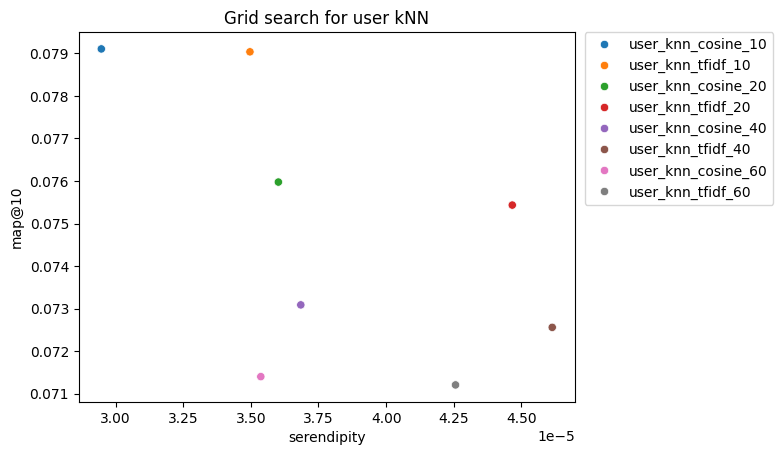

In [67]:
sns.scatterplot(data = tuning_df[tuning_df.serendipity > 0], x="serendipity", y="map@10", hue="model", legend=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title("Grid search for user kNN")
plt.show()

__По графику видно, что наилучшей моделью с точки зрения качества является user kNN с использование Cosine на 10 ближайших соседях. Но при том же качестве есть модель на TF-IDF с лучшим значением Serendipity. При этом не нужно забывать, что использовалось только 5-ая часть соседей и на большем количестве юзеров модель с большим количество соседей может сработать лучше__

__Таким образом в качестве финальной модели была использования user kNN на TFIDF и на 20 соседях__

In [68]:
tuning_final_interactions = Interactions(interactions_df.copy())

In [70]:
tuning_final_models = {
    'user_knn': UserKnn(model=TFIDFRecommender(20), n_similar_users=20)
}
tuning_final_metrics = {
    'map@10': MAP(k=K_RECOMMENDATIONS),
    'serendipity': Serendipity(k=K_RECOMMENDATIONS),
}

In [71]:
tuning_final_splitter = TimeRangeSplitter(
    test_size="7D",
    n_splits=1,
    filter_already_seen=True,
    filter_cold_items=True,
    filter_cold_users=False
)

In [72]:
fold_iterator = tuning_final_splitter.split(tuning_final_interactions, collect_fold_stats=True)

tuning_final_results = []

for i_fold, (train_ids, test_ids, fold_info) in enumerate(fold_iterator):
    print(f"\n==================== Fold {i_fold}")
    df_train = tuning_final_interactions.df.iloc[train_ids].copy()
    df_test = tuning_final_interactions.df.iloc[test_ids][Columns.UserItem].copy()
    test_users = df_test[Columns.User].unique()
    catalog = df_train[Columns.Item].unique()
    
    for model_name, model in tuning_final_models.items():
        model.fit(df_train)
    
        recos = model.recommend(test_users, k=K_RECOMMENDATIONS)
    
        metric_values = calc_metrics(
            tuning_final_metrics,
            reco=recos,
            interactions=df_test,
            prev_interactions=df_train,
            catalog=catalog,
        )
    
        fold = {"fold": i_fold, "model": model_name}
        fold.update(metric_values)
        tuning_final_results.append(fold)


==================== Fold 0
176549


  0%|          | 0/906071 [00:00<?, ?it/s]

In [74]:
tuning_final_report_df = pd.DataFrame(tuning_final_results)

In [75]:
tuning_final_report_df

,fold,model,map@10,serendipity
0,0,user_knn,0.078371,0.000043


## Обучение модели для сервиса и сохранение

__Обучим модель с финальными параметрами и сохраним её артефакты для использования в сервисе__

In [475]:
model = UserKnn(model=TFIDFRecommender(20), n_similar_users=20)
model.fit(interactions_df)

176549


  0%|          | 0/962179 [00:00<?, ?it/s]

In [476]:
model.model.save("user_knn.npz")

In [477]:
user_item_matrix  = model._get_item_user_matrix(df_train)
sparse.save_npz("matrix_for_user_knn.npz", user_item_matrix)

In [478]:
# from external to internal user_id
users_mapping = {int(k): int(v) for (k, v) in model.users_mapping.items()}
with open("users_mapping.json", "w") as f:
    json.dump(users_mapping, f)

In [479]:
# from internal to external item_id
items_inv_mapping = {int(k): int(v) for (k, v) in model.items_inv_mapping.items()}
with open("items_inv_mapping.json", "w") as f:
    json.dump(items_inv_mapping, f)

In [480]:
top_items = [int(item_id) for item_id in model.top_items]
with open("top_items.json", "w") as f:
    json.dump({"items": top_items}, f)

In [481]:
item_idfs = [float(v) for v in model.item_idf.idf.values]
with open("item_idfs.json", "w") as f:
    json.dump({"items": item_idfs}, f)